# Anomaly Detection

This notebook will detail how four algorithms—Rolling Mean, ARIMA, Autoencoder, and Combination Random Cut Forest—can be used to detect anomalies in my five time series datasets. These are unsupervised algorithms, so three different definitions for "anomaly" will be used: standard deviations from the data mean, standard deviations from the mean of errors, and nonparametric dynamic thresholding (an approach [recently proposed by JPL](https://arxiv.org/abs/1802.04431)). In other words, this will perform the right half of the following diagram.

<img src="explore/Experiments_Diagram.jpg">




## First let's import everything

In [3]:
# Standard modules
import os
import sys
import datetime
import pandas as pd
from pandas import datetime
from pandas import read_csv
import numpy as np
from matplotlib import pyplot
import progressbar

# Custom modules
from detect_anomalies import *

In [4]:
datasets = ['Data/BusVoltage.csv', 'Data/TotalBusCurrent.csv', 'Data/BatteryTemperature.csv', 'Data/WheelTemperature.csv', 'Data/WheelRPM.csv']

## Detect anomalies
Remember that the general approach for unsupervised anomaly detection is to generate a model of what's "normal" for the data, then when the data "differs greatly" from that model, we call that anomalous. For each dataset, we will use four different "normal" model algorithms (rolling mean, ARIMA, autoencoder, and combination random cut forest). For each model, we will define "differs greatly" three different ways (standard deviations from the mean of the data, standard deviations from the mean of the errors, and nonparametric dynamic thresholding). The detected anomalies will be plotted and saved. 

Combination random cut forests are different from the other three algorithms in that instead of generating a "normal" model they assign an anomaly score to each data point. Because of this, standard deviations from the mean of the data (which requires a "normal" model) will not be considered for the forests.

## Rolling Mean

### Standard deviations from the mean of the data
When the data strays more than `n` standard deviations from the "normal" model (the rolling mean in this case), we'll call that anomalous. 

Detected outliers (BusVoltage, 2 stds): 96
Detected outliers (BusVoltage, 4 stds): 27
Detected outliers (BusVoltage, 8 stds): 6


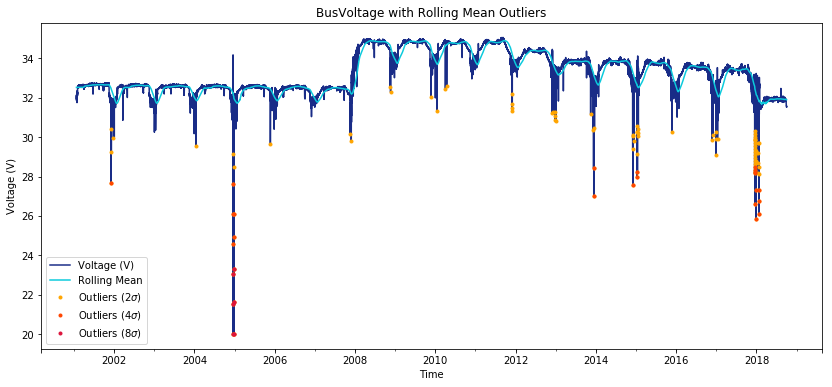

Detected outliers (TotalBusCurrent, 2 stds): 172
Detected outliers (TotalBusCurrent, 4 stds): 36


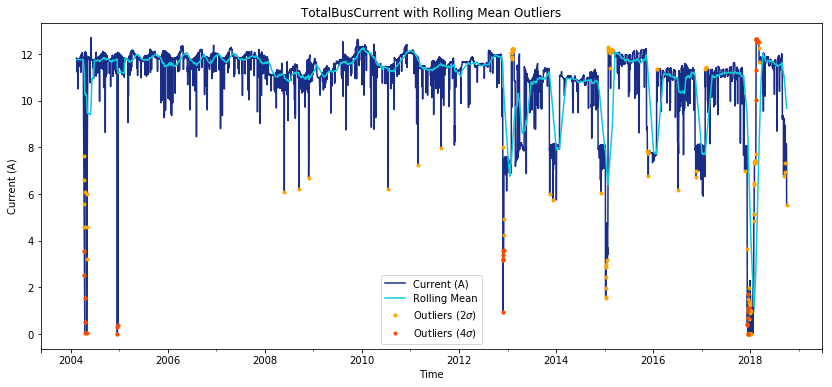

Detected outliers (BatteryTemperature, 2 stds): 1712
Detected outliers (BatteryTemperature, 4 stds): 13


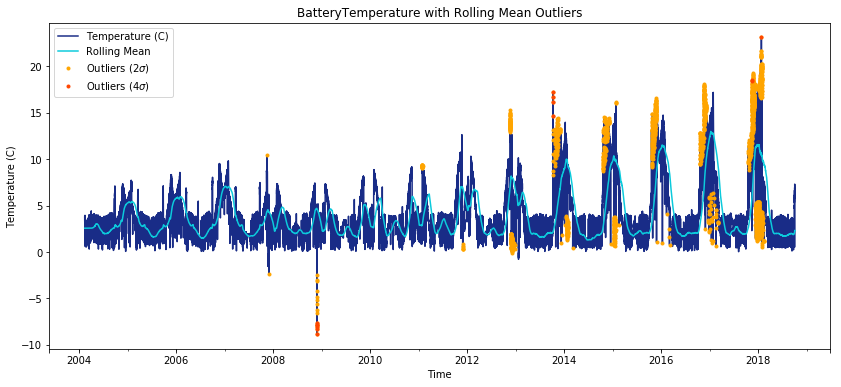

Detected outliers (WheelTemperature, 2 stds): 39720
Detected outliers (WheelTemperature, 4 stds): 5212
Detected outliers (WheelTemperature, 8 stds): 15


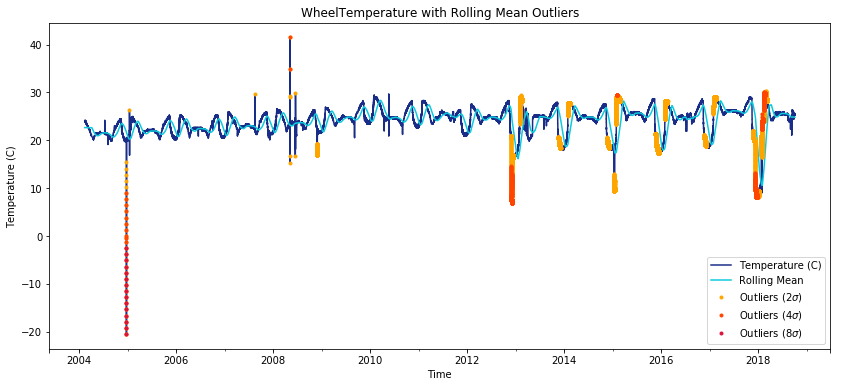

Detected outliers (WheelRPM, 2 stds): 19627


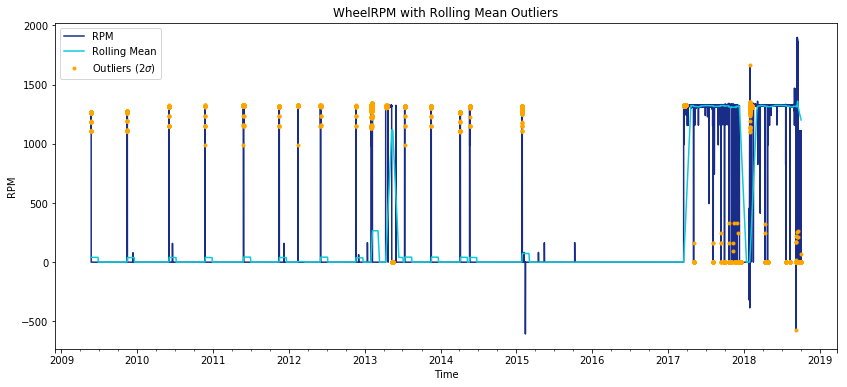

<Figure size 432x288 with 0 Axes>

In [3]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_with_rolling_mean.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/rolling mean/plots/' + ds_name + '_rolling_mean_outliers_from_data_mean.png' 
    data_file = './save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_rolling_mean_outliers_from_data_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='std', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)


### Standard deviations from the mean of the errors
When the error—the difference between a data value and the "normal" model's corresponding value—is greater than the mean of all the errors plus `n` times the standard deviation of the errors, we'll call that anomalous.

Detected outliers (BusVoltage, 2 stds): 1688
Detected outliers (BusVoltage, 4 stds): 167
Detected outliers (BusVoltage, 8 stds): 58


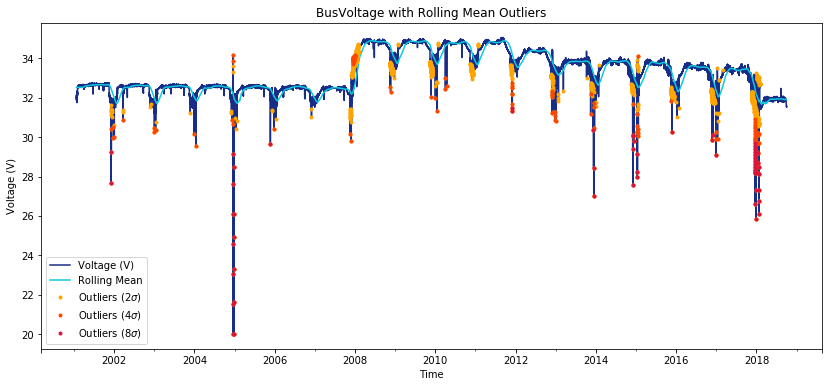

Detected outliers (TotalBusCurrent, 2 stds): 241
Detected outliers (TotalBusCurrent, 4 stds): 73
Detected outliers (TotalBusCurrent, 8 stds): 7


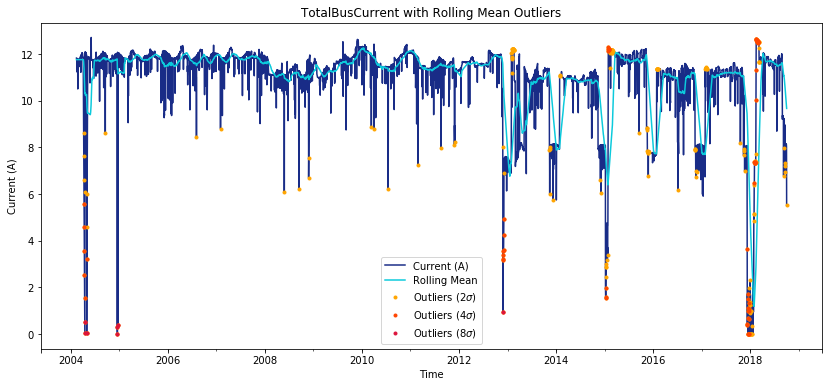

Detected outliers (BatteryTemperature, 2 stds): 5656
Detected outliers (BatteryTemperature, 4 stds): 830
Detected outliers (BatteryTemperature, 8 stds): 4


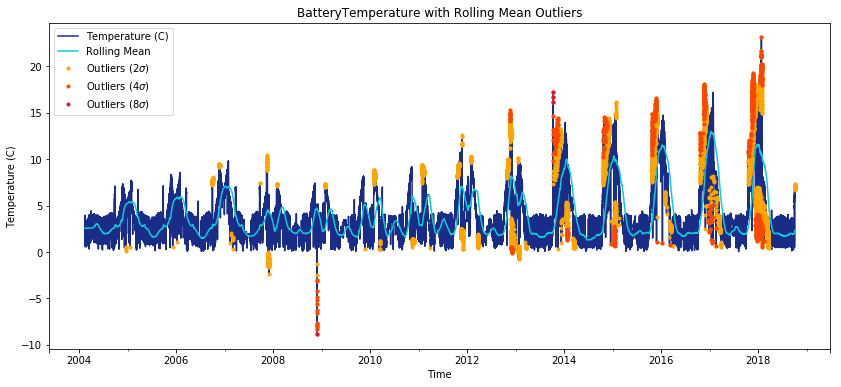

Detected outliers (WheelTemperature, 2 stds): 41741
Detected outliers (WheelTemperature, 4 stds): 9818
Detected outliers (WheelTemperature, 8 stds): 415


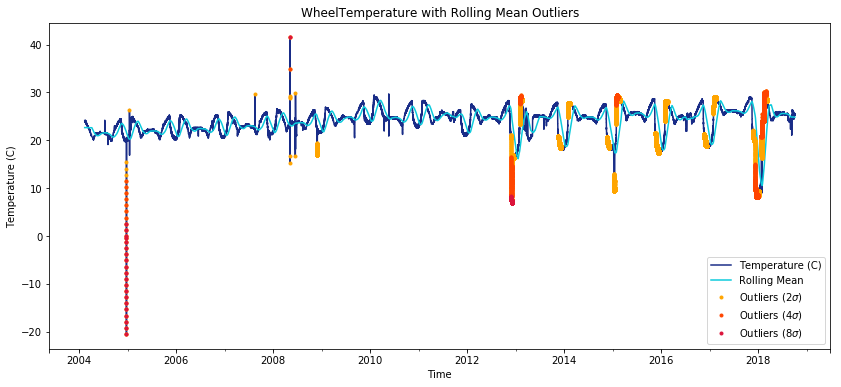

Detected outliers (WheelRPM, 2 stds): 41375
Detected outliers (WheelRPM, 4 stds): 24941
Detected outliers (WheelRPM, 8 stds): 2


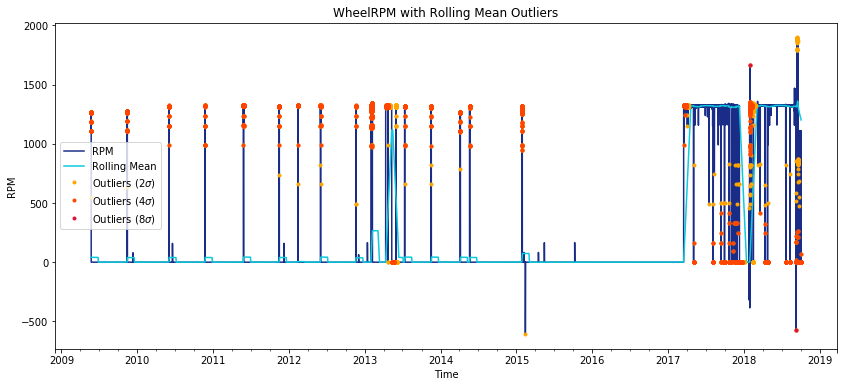

<Figure size 432x288 with 0 Axes>

In [4]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_with_rolling_mean.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/rolling mean/plots/' + ds_name + '_rolling_mean_outliers_from_error_mean.png' 
    data_file = './save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_rolling_mean_outliers_from_error_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='errors', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)
    

### Nonparametric dynamic thresholding
This approach, proposed by NASA's JPL, does its own magic to label points as anomalous or not. Although "nonparametric" is in the name, we use the following configurations:

`batch_size = 70` _(number of values to evaluate in each batch)_

`window_size = 30` _(number of trailing batches to use in error calculation)_

`smoothing_perc = 0.05` _(determines window size used in EWMA smoothing (percentage of total values for channel))_ 

`l_s = 250` _(num previous timesteps provided to model to predict future values)_

`error_buffer = 100` _(number of values surrounding an error that are brought into the sequence (promotes grouping on nearby sequences))_

`p = 0.35` _(minimum percent decrease between max errors in anomalous sequences (used for pruning))_

Detected outliers (BusVoltage): 3828


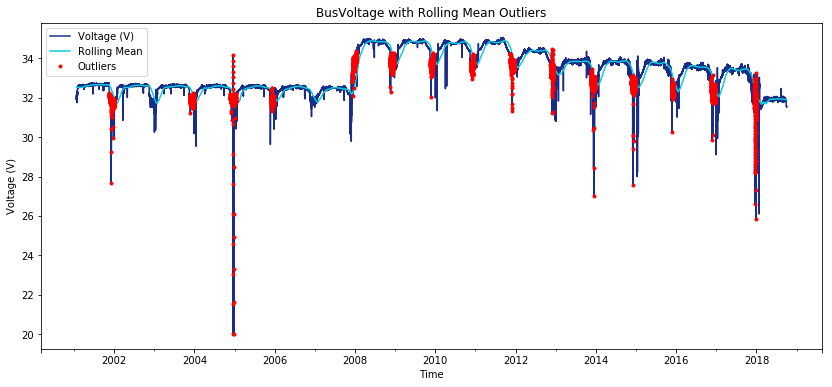

Detected outliers (TotalBusCurrent): 700


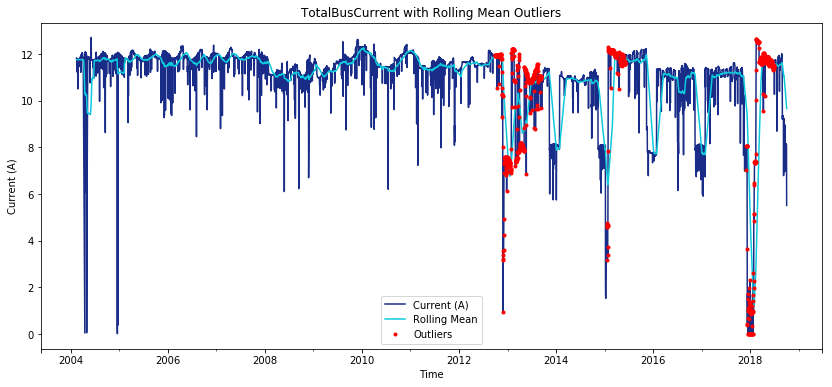

Detected outliers (BatteryTemperature): 5180


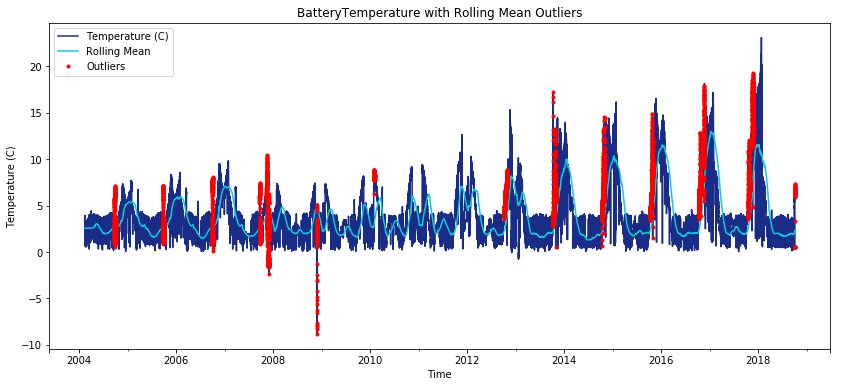

Detected outliers (WheelTemperature): 15770


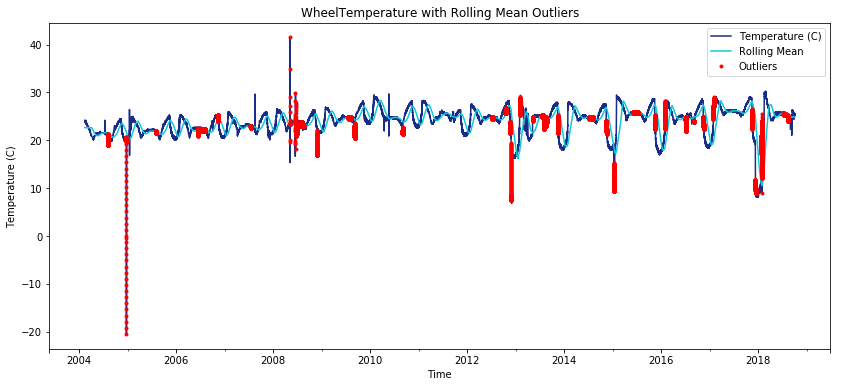

Detected outliers (WheelRPM): 15130


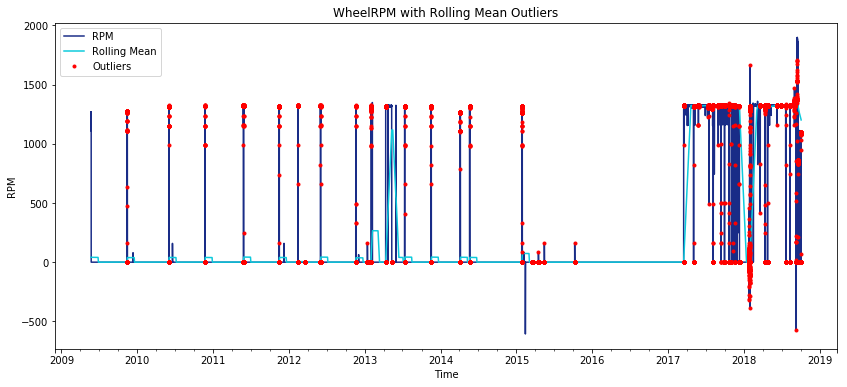

<Figure size 432x288 with 0 Axes>

In [10]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_with_rolling_mean.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/rolling mean/plots/' + ds_name + '_rolling_mean_outliers_from_dynamic_thresholding.png' 
    data_file = './save/datasets/' + ds_name + '/rolling mean/data/' + ds_name + '_rolling_mean_outliers_from_dynamic_thresholding.csv' 
    
    data = detect_anomalies(X, Y, ds_name, var_name, alg_name, outlier_def='dynamic',
                            plot_save_path=plot_file, data_save_path=data_file)


## ARIMA (trained on 50% of each dataset)

### Standard deviations from the mean of the data

Detected outliers (BusVoltage, 2 stds): 2404
Detected outliers (BusVoltage, 4 stds): 675
Detected outliers (BusVoltage, 8 stds): 364


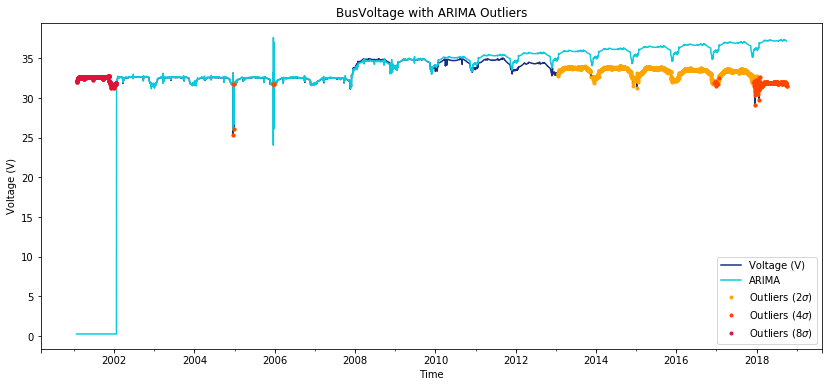

Detected outliers (TotalBusCurrent, 2 stds): 927
Detected outliers (TotalBusCurrent, 4 stds): 431


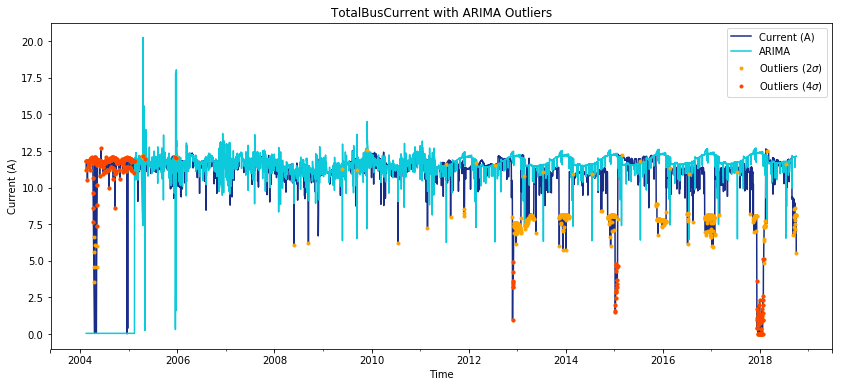

Detected outliers (BatteryTemperature, 2 stds): 242
Detected outliers (BatteryTemperature, 4 stds): 11


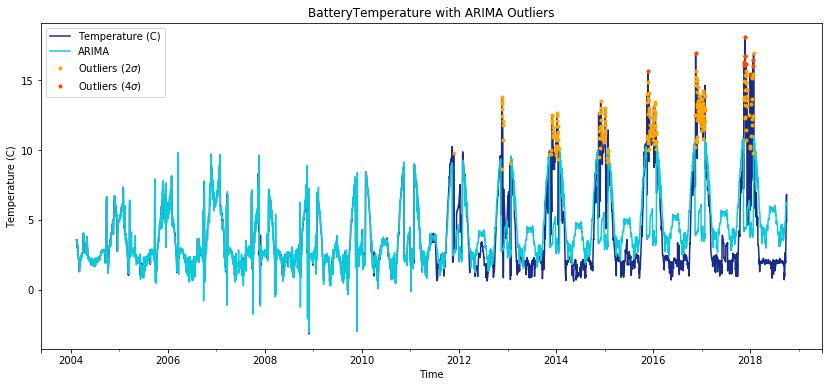

Detected outliers (WheelTemperature, 2 stds): 810
Detected outliers (WheelTemperature, 4 stds): 424
Detected outliers (WheelTemperature, 8 stds): 44


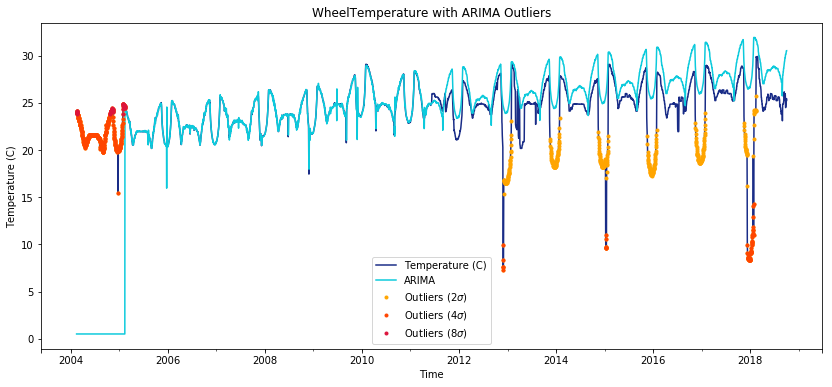

Detected outliers (WheelRPM, 2 stds): 572


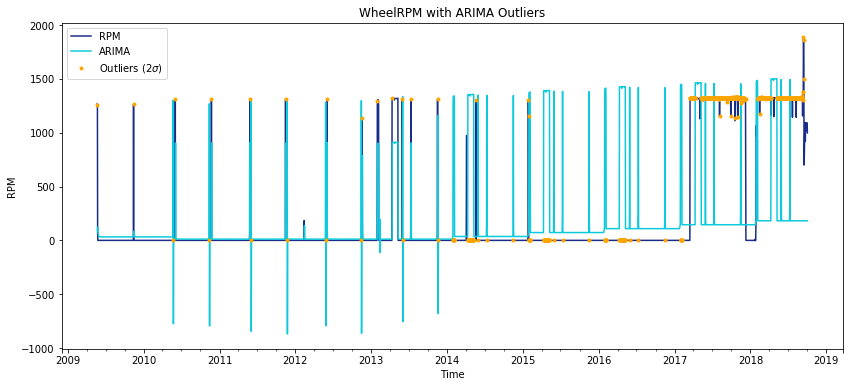

<Figure size 432x288 with 0 Axes>

In [4]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_with_arima_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/50 percent/' + ds_name + '_arima_half_outliers_from_data_mean.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_arima_half_outliers_from_data_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='std', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)


### Standard deviations from the mean of the errors

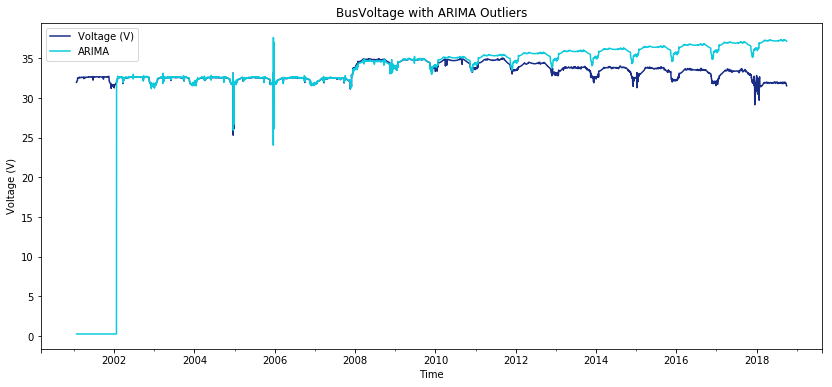

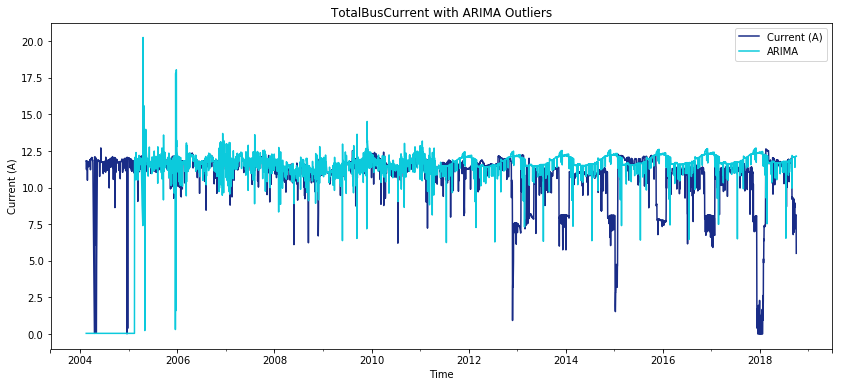

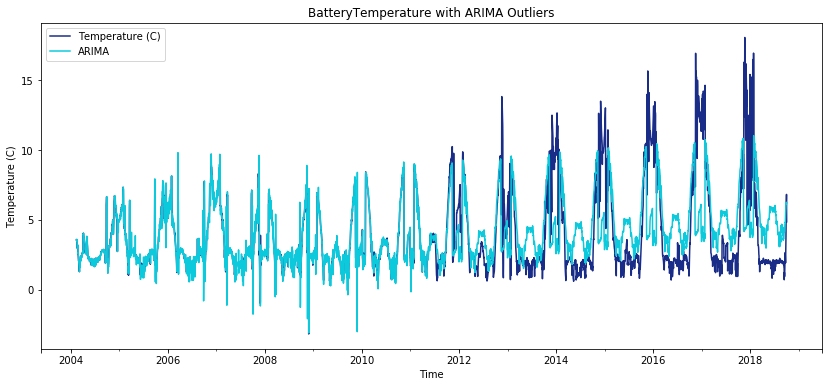

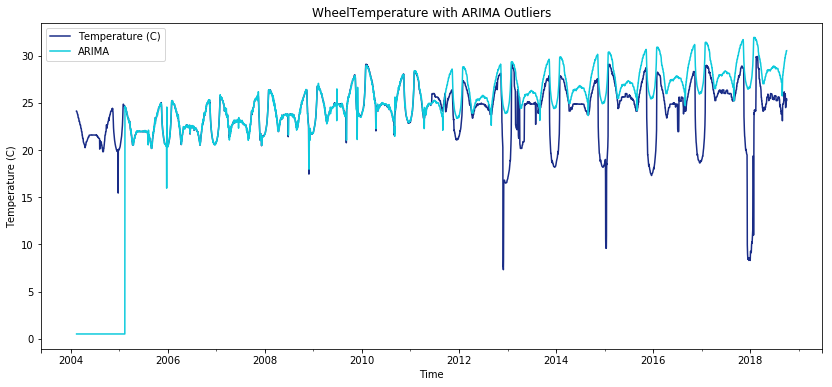

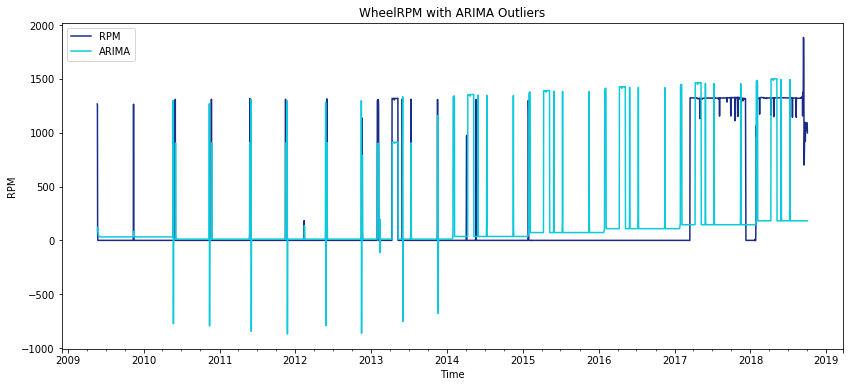

<Figure size 432x288 with 0 Axes>

In [5]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_with_arima_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/50 percent/' + ds_name + '_arima_half_outliers_from_error_mean.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_arima_half_outliers_from_error_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='errors', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)
    

### Nonparametric dynamic thresholding

Detected outliers (BusVoltage): 280


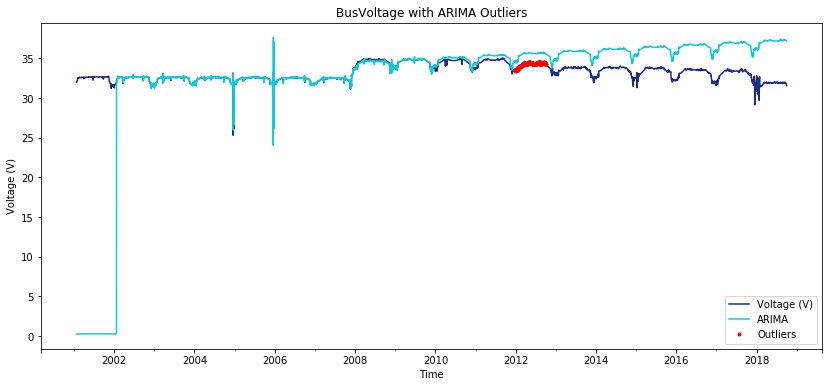

Detected outliers (TotalBusCurrent): 750


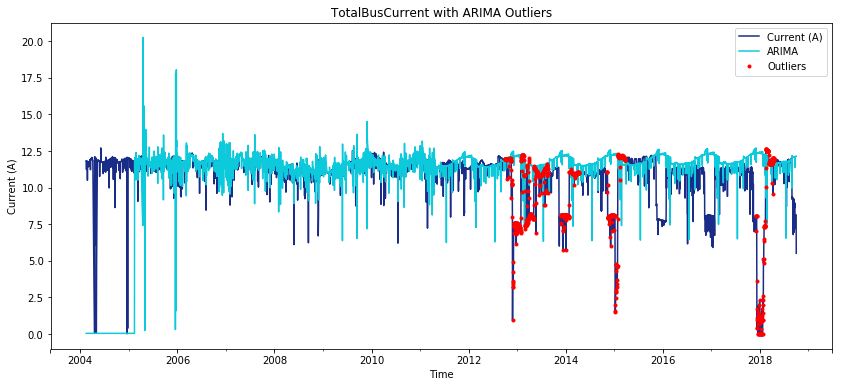

Detected outliers (BatteryTemperature): 910


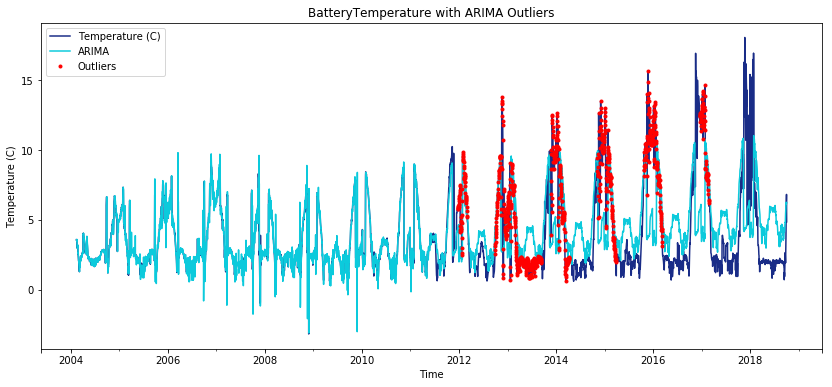

Detected outliers (WheelTemperature): 1093


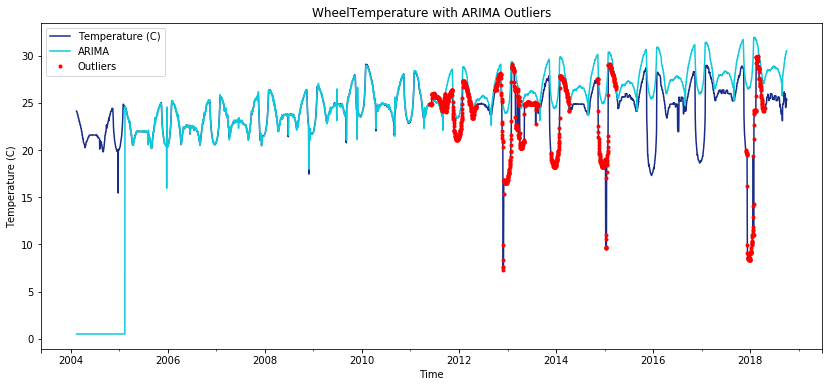

Detected outliers (WheelRPM): 210


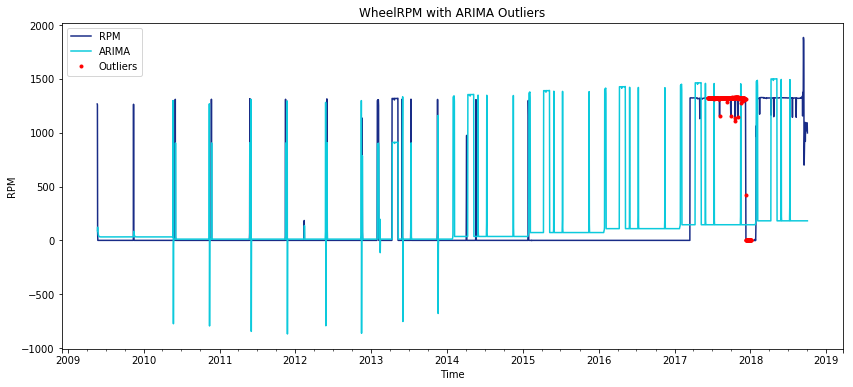

<Figure size 432x288 with 0 Axes>

In [13]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_with_arima_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/50 percent/' + ds_name + '_arima_half_outliers_from_dynamic_thresholding.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/50 percent/' + ds_name + '_arima_half_outliers_from_dynamic_thresholding.csv' 
    
    data = detect_anomalies(X, Y, ds_name, var_name, alg_name, outlier_def='dynamic',
                            plot_save_path=plot_file, data_save_path=data_file)
    

## ARIMA (trained on whole datasets)

### Standard deviations from the mean of the data

Detected outliers (BusVoltage, 2 stds): 373
Detected outliers (BusVoltage, 4 stds): 372
Detected outliers (BusVoltage, 8 stds): 364


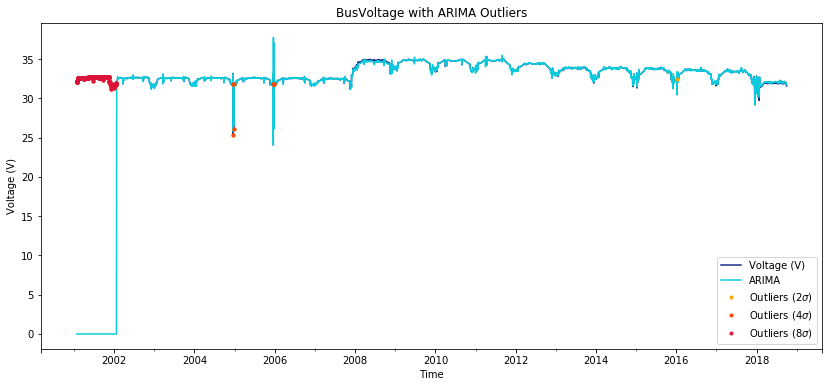

Detected outliers (TotalBusCurrent, 2 stds): 385
Detected outliers (TotalBusCurrent, 4 stds): 355


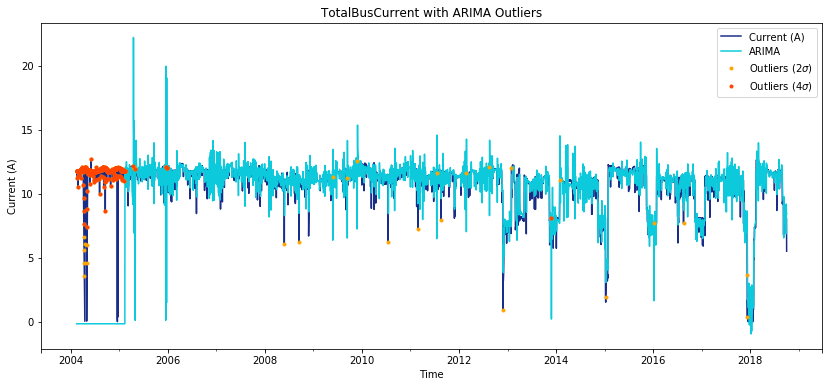

Detected outliers (BatteryTemperature, 2 stds): 27


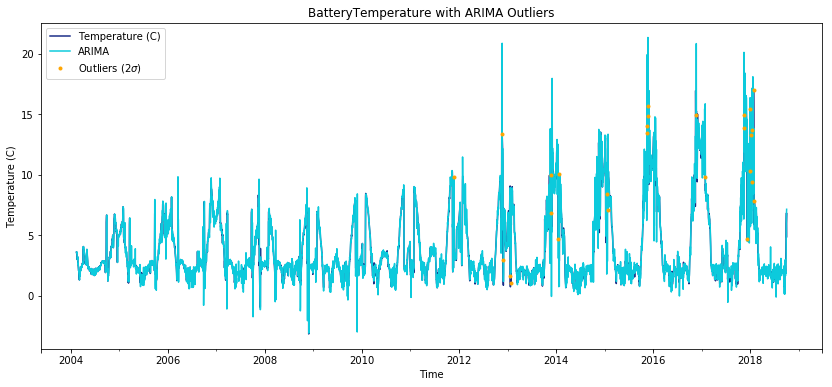

Detected outliers (WheelTemperature, 2 stds): 374
Detected outliers (WheelTemperature, 4 stds): 364
Detected outliers (WheelTemperature, 8 stds): 65


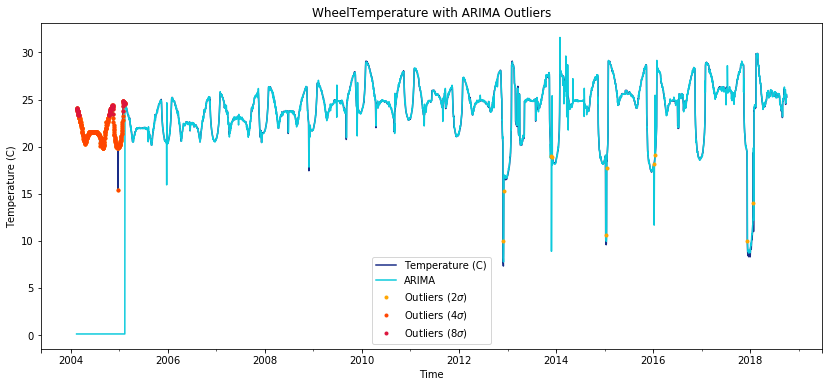

Detected outliers (WheelRPM, 2 stds): 58


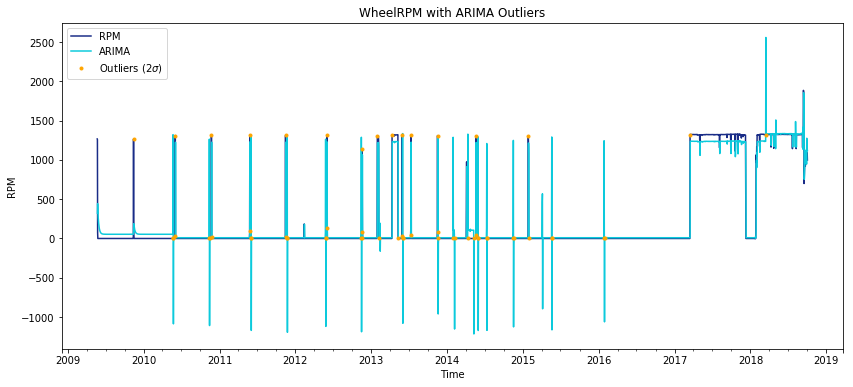

<Figure size 432x288 with 0 Axes>

In [6]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_with_arima_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/100 percent/' + ds_name + '_arima_full_outliers_from_data_mean.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_arima_full_outliers_from_data_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='std', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)


### Standard deviations from the mean of the errors

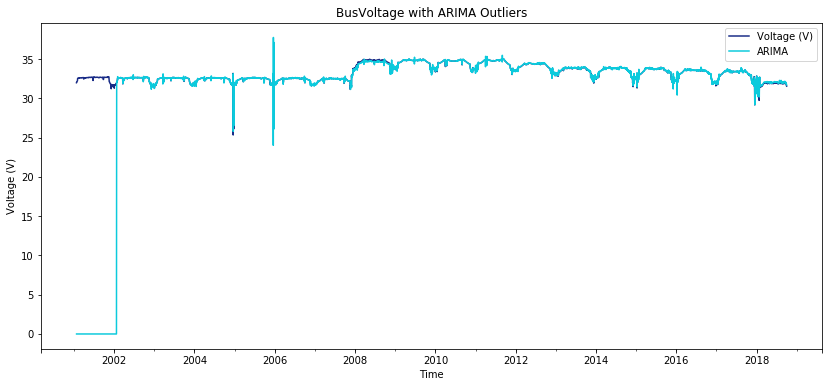

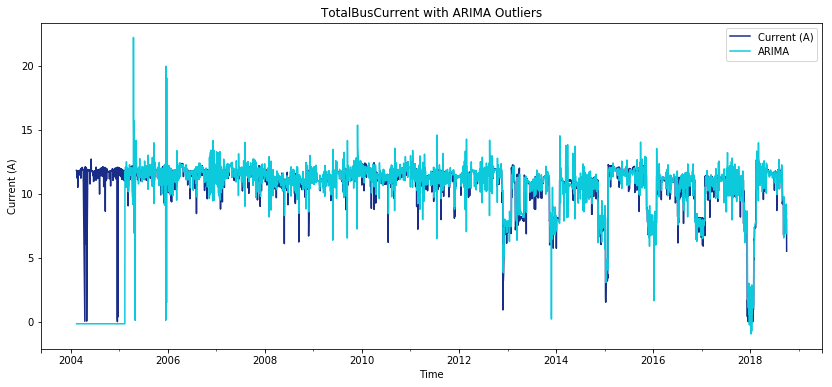

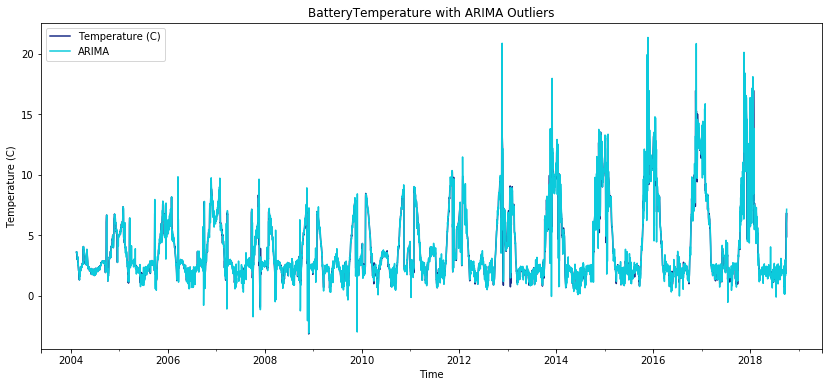

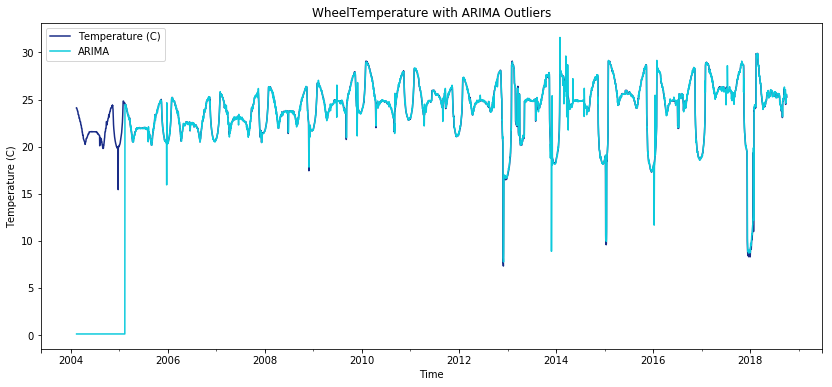

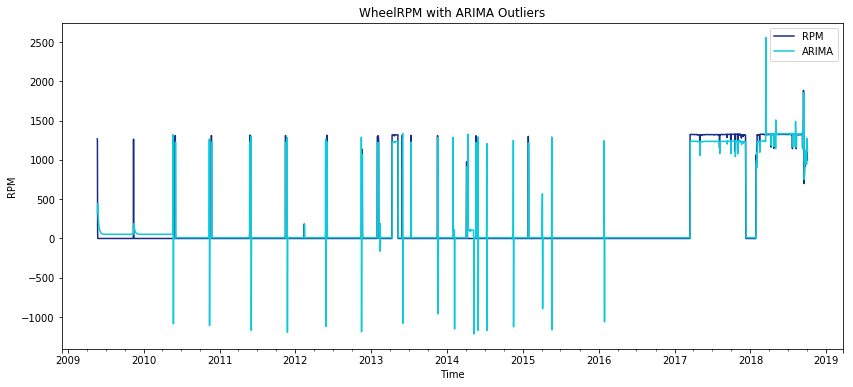

<Figure size 432x288 with 0 Axes>

In [7]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_with_arima_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/100 percent/' + ds_name + '_arima_full_outliers_from_error_mean.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_arima_full_outliers_from_error_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='errors', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)
    

### Nonparametric dynamic thresholding

Detected outliers (BusVoltage): 350


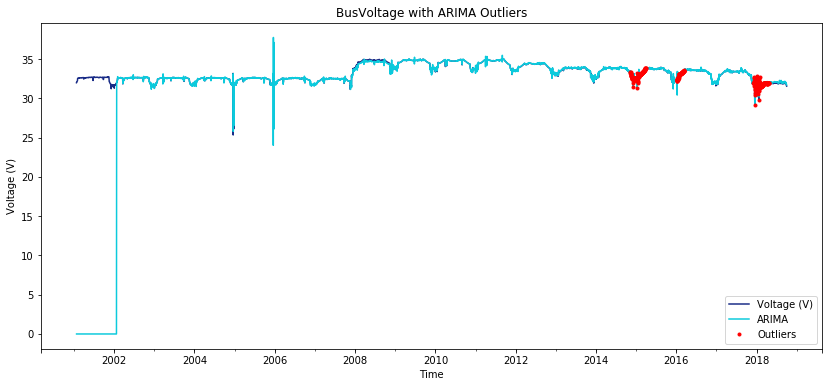

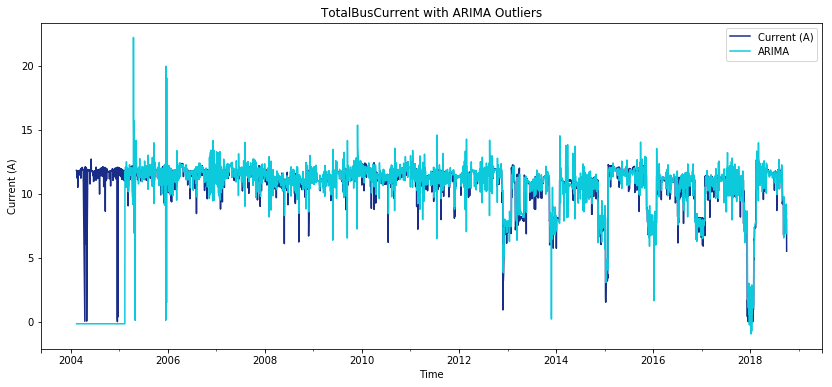

Detected outliers (BatteryTemperature): 140


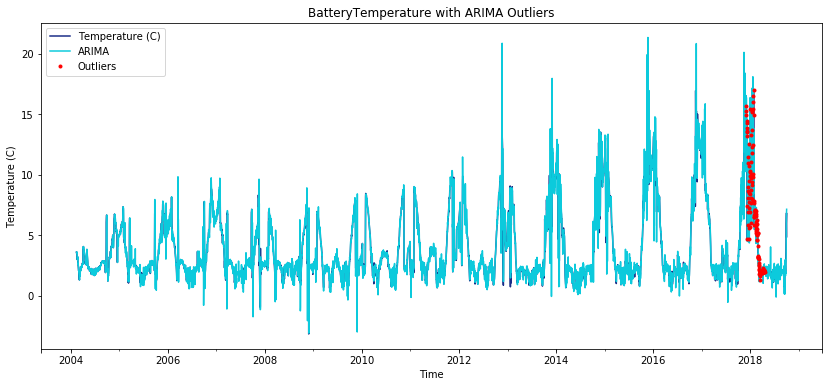

Detected outliers (WheelTemperature): 630


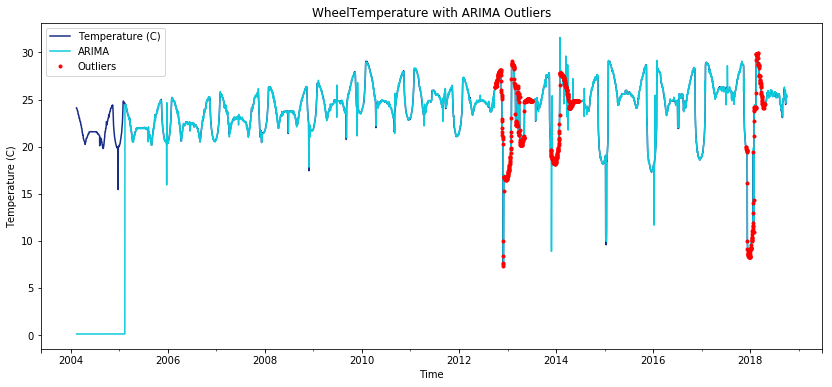

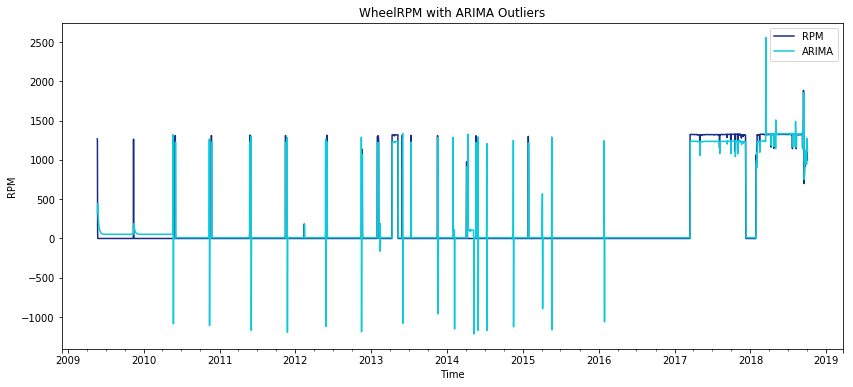

<Figure size 432x288 with 0 Axes>

In [14]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_with_arima_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/arima/plots/100 percent/' + ds_name + '_arima_full_outliers_from_dynamic_thresholding.png' 
    data_file = './save/datasets/' + ds_name + '/arima/data/100 percent/' + ds_name + '_arima_full_outliers_from_dynamic_thresholding.csv' 
    
    data = detect_anomalies(X, Y, ds_name, var_name, alg_name, outlier_def='dynamic',
                            plot_save_path=plot_file, data_save_path=data_file)
    

## Autoencoder (trained on 50% of each dataset)

### Standard deviations from the mean of the data

Detected outliers (BusVoltage, 2 stds): 87
Detected outliers (BusVoltage, 4 stds): 19
Detected outliers (BusVoltage, 8 stds): 2


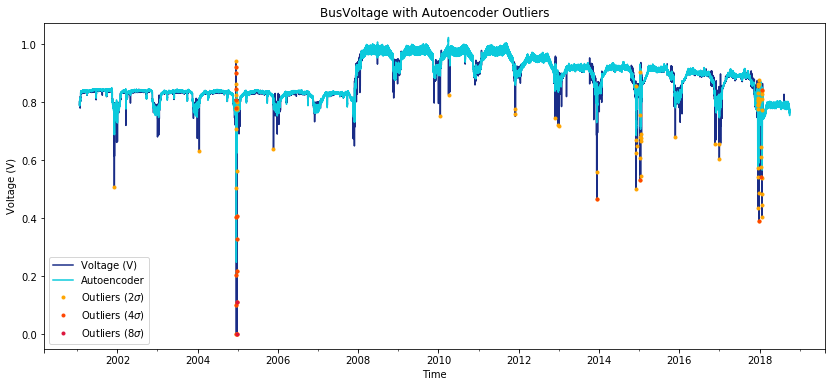

Detected outliers (TotalBusCurrent, 2 stds): 129
Detected outliers (TotalBusCurrent, 4 stds): 23


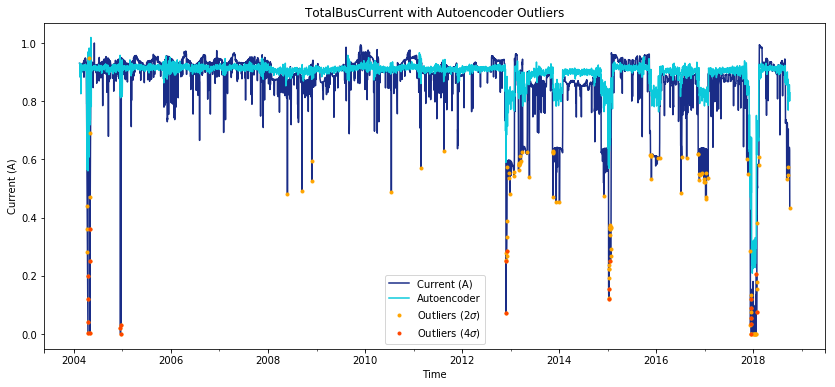

Detected outliers (BatteryTemperature, 2 stds): 216
Detected outliers (BatteryTemperature, 4 stds): 9


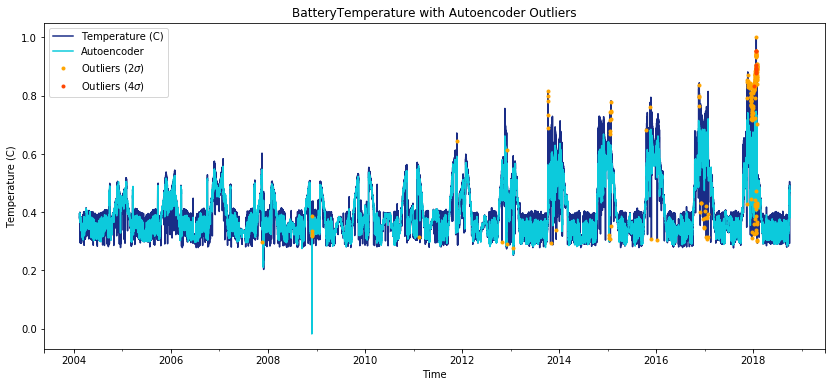

Detected outliers (WheelTemperature, 2 stds): 33
Detected outliers (WheelTemperature, 4 stds): 12
Detected outliers (WheelTemperature, 8 stds): 2


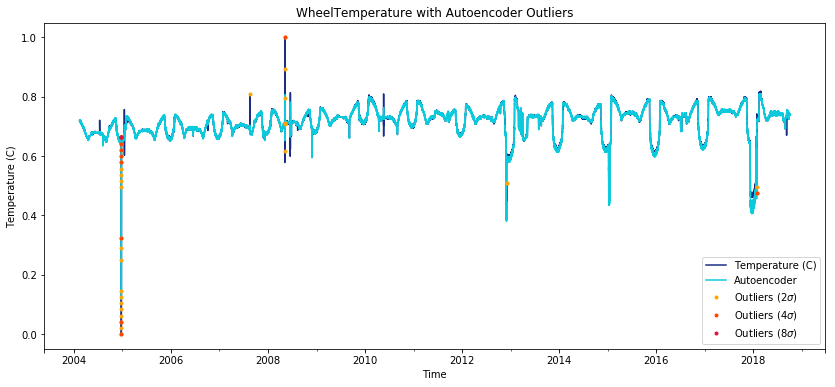

Detected outliers (WheelRPM, 2 stds): 98


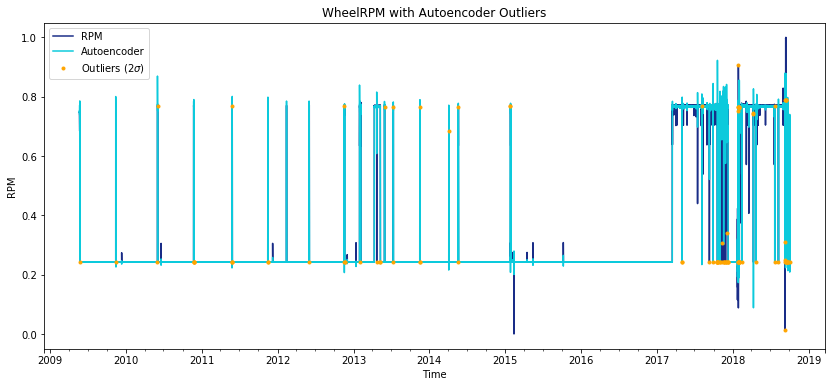

<Figure size 432x288 with 0 Axes>

In [8]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_with_autoencoder_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/50 percent/' + ds_name + '_autoencoder_half_outliers_from_data_mean.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_autoencoder_half_outliers_from_data_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='std', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)


### Standard deviations from the mean of the errors

Detected outliers (BusVoltage, 2 stds): 729
Detected outliers (BusVoltage, 4 stds): 301
Detected outliers (BusVoltage, 8 stds): 133


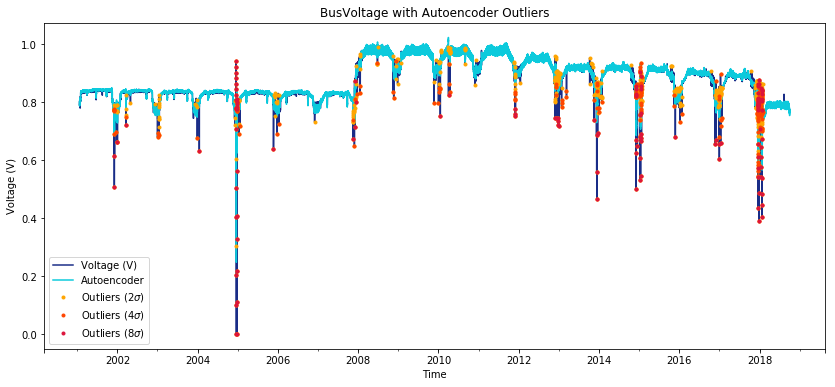

Detected outliers (TotalBusCurrent, 2 stds): 298
Detected outliers (TotalBusCurrent, 4 stds): 52
Detected outliers (TotalBusCurrent, 8 stds): 5


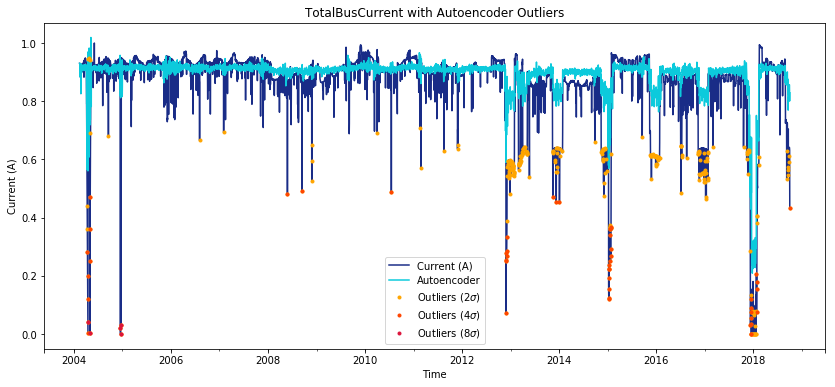

Detected outliers (BatteryTemperature, 2 stds): 4514
Detected outliers (BatteryTemperature, 4 stds): 1226
Detected outliers (BatteryTemperature, 8 stds): 162


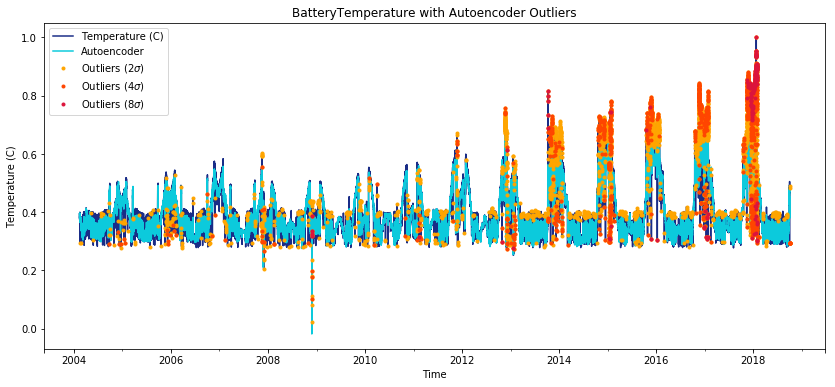

Detected outliers (WheelTemperature, 2 stds): 11034
Detected outliers (WheelTemperature, 4 stds): 8537
Detected outliers (WheelTemperature, 8 stds): 3799


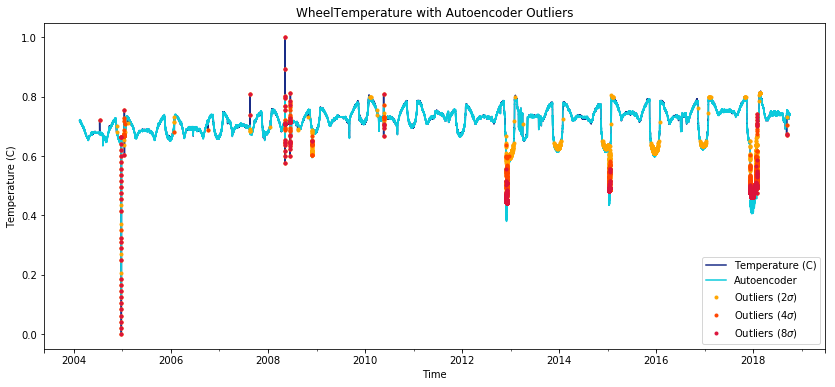

Detected outliers (WheelRPM, 2 stds): 7676
Detected outliers (WheelRPM, 4 stds): 4117
Detected outliers (WheelRPM, 8 stds): 2141


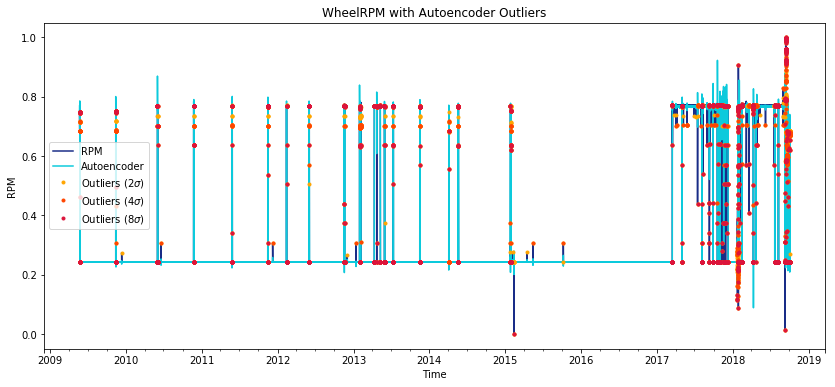

<Figure size 432x288 with 0 Axes>

In [11]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_with_autoencoder_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/50 percent/' + ds_name + '_autoencoder_half_outliers_from_error_mean.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_autoencoder_half_outliers_from_error_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='errors', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)
    

### Nonparametric dynamic thresholding

Detected outliers (BusVoltage): 560


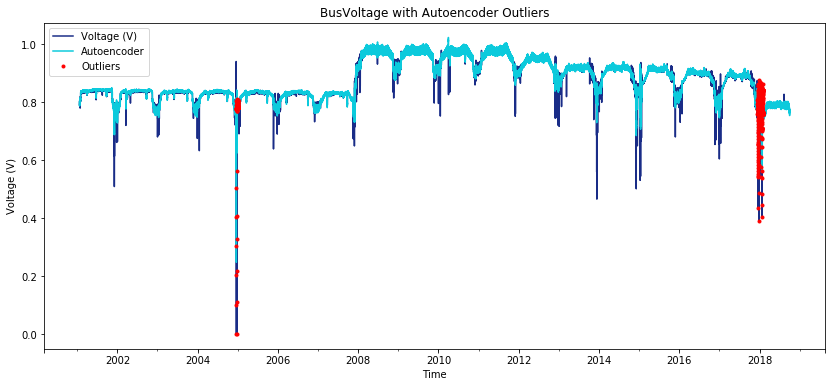

Detected outliers (TotalBusCurrent): 673


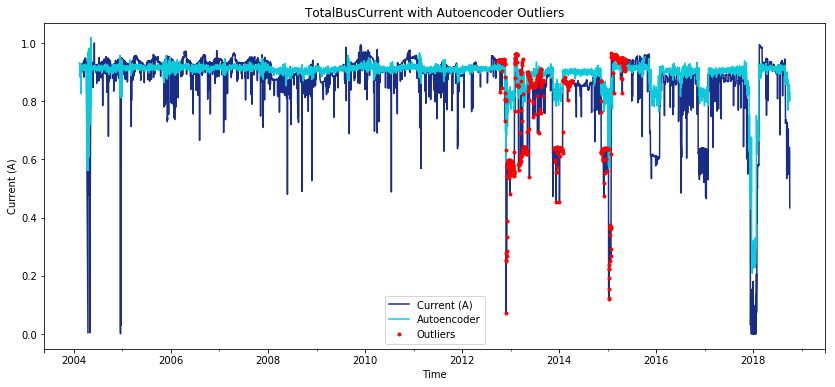

Detected outliers (BatteryTemperature): 1260


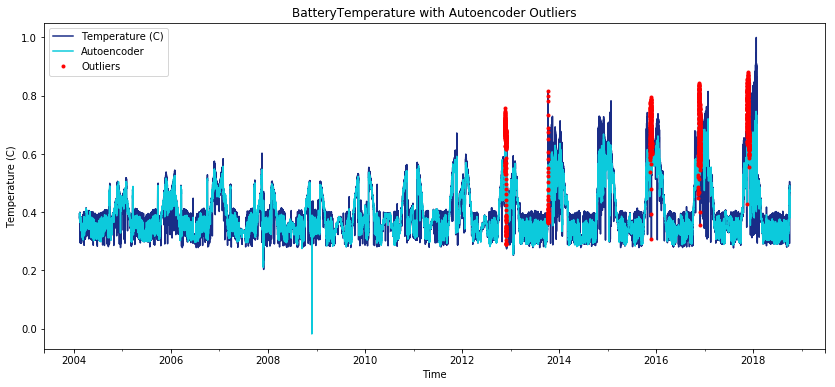

Detected outliers (WheelTemperature): 210


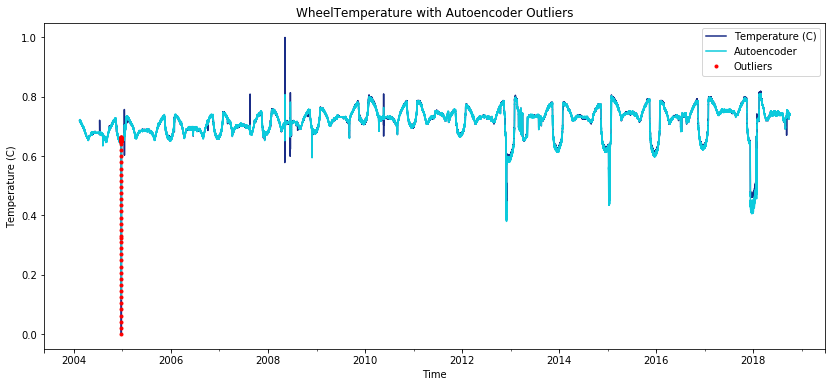

Detected outliers (WheelRPM): 5343


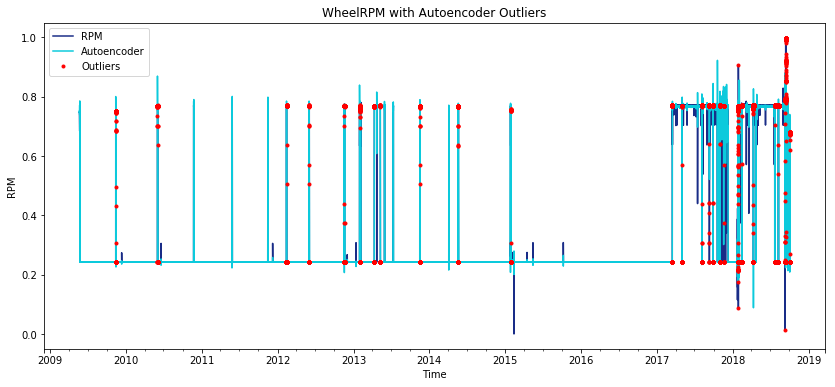

<Figure size 432x288 with 0 Axes>

In [15]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_with_autoencoder_half.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/50 percent/' + ds_name + '_autoencoder_half_outliers_from_dynamic_thresholding.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/50 percent/' + ds_name + '_autoencoder_half_outliers_from_dynamic_thresholding.csv' 
    
    data = detect_anomalies(X, Y, ds_name, var_name, alg_name, outlier_def='dynamic',
                            plot_save_path=plot_file, data_save_path=data_file)
    

## Autoencoder (trained on whole datasets)

### Standard deviations from the mean of the data

Detected outliers (BusVoltage, 2 stds): 84
Detected outliers (BusVoltage, 4 stds): 17
Detected outliers (BusVoltage, 8 stds): 1


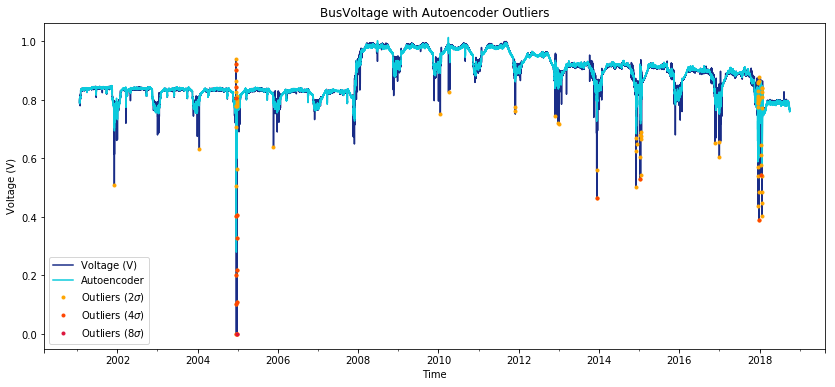

Detected outliers (TotalBusCurrent, 2 stds): 56
Detected outliers (TotalBusCurrent, 4 stds): 7


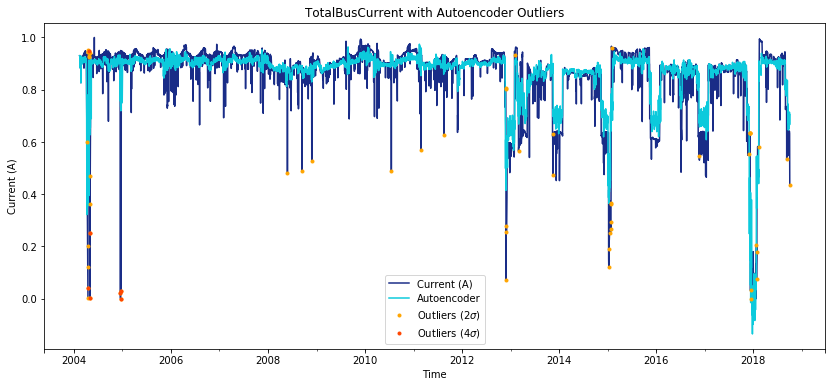

Detected outliers (BatteryTemperature, 2 stds): 132


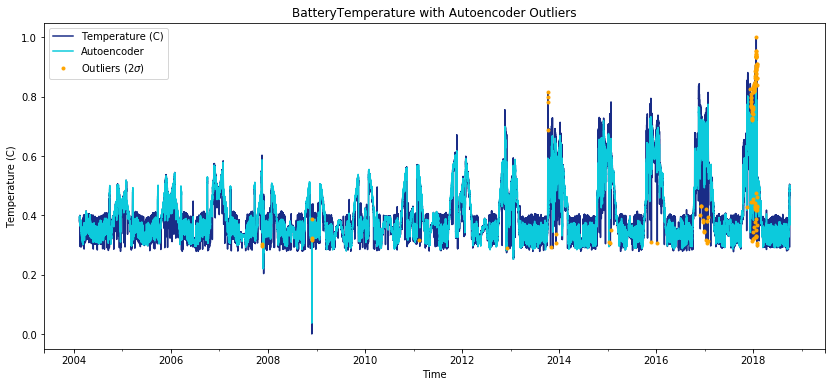

Detected outliers (WheelTemperature, 2 stds): 36
Detected outliers (WheelTemperature, 4 stds): 15
Detected outliers (WheelTemperature, 8 stds): 1


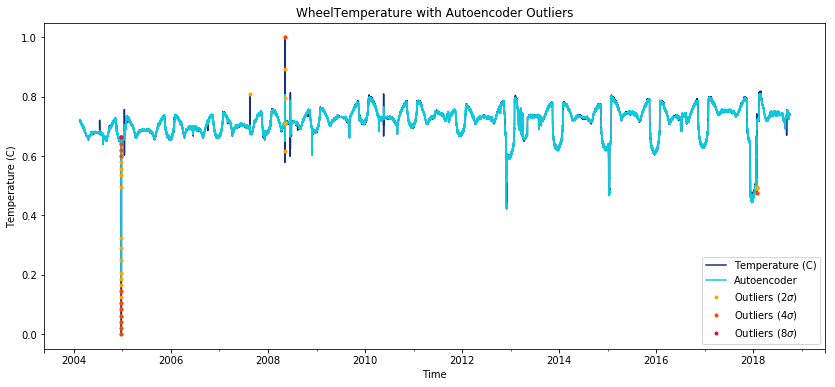

Detected outliers (WheelRPM, 2 stds): 17


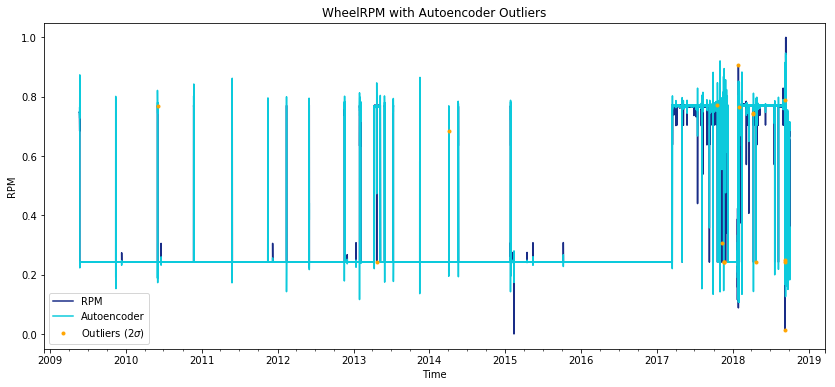

<Figure size 432x288 with 0 Axes>

In [12]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_with_autoencoder_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/100 percent/' + ds_name + '_autoencoder_full_outliers_from_data_mean.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_autoencoder_full_outliers_from_data_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='std', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)


### Standard deviations from the mean of the errors

Detected outliers (BusVoltage, 2 stds): 839
Detected outliers (BusVoltage, 4 stds): 314
Detected outliers (BusVoltage, 8 stds): 142


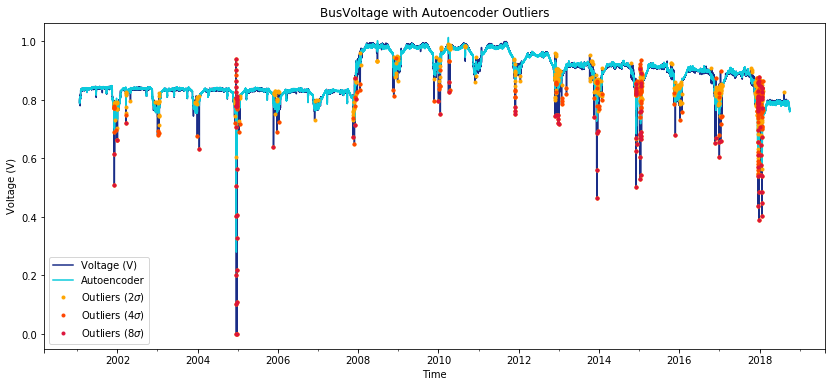

Detected outliers (TotalBusCurrent, 2 stds): 207
Detected outliers (TotalBusCurrent, 4 stds): 63
Detected outliers (TotalBusCurrent, 8 stds): 9


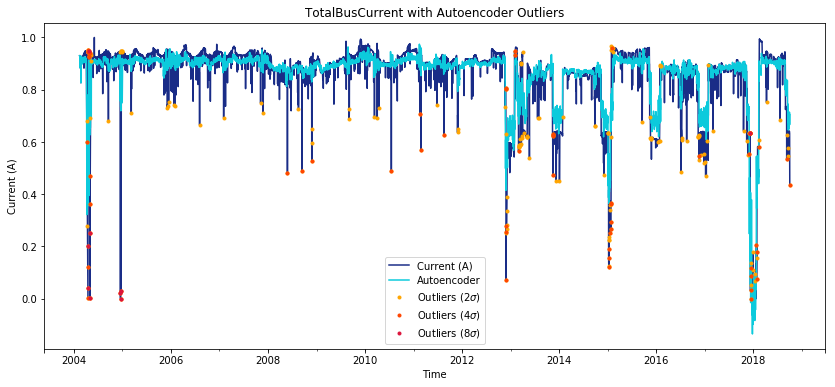

Detected outliers (BatteryTemperature, 2 stds): 4006
Detected outliers (BatteryTemperature, 4 stds): 946
Detected outliers (BatteryTemperature, 8 stds): 227


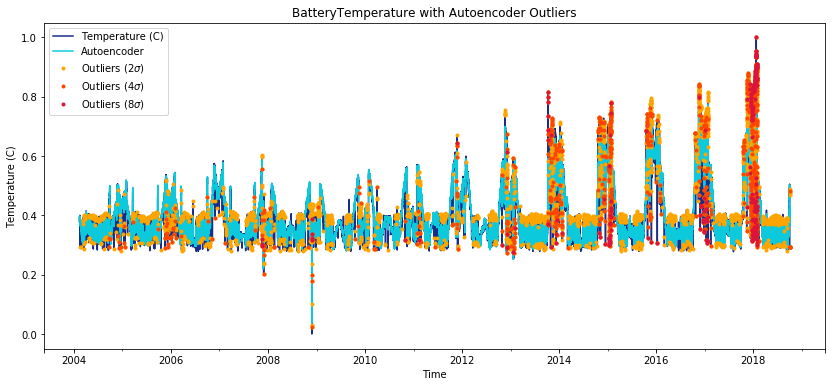

Detected outliers (WheelTemperature, 2 stds): 18445
Detected outliers (WheelTemperature, 4 stds): 4218
Detected outliers (WheelTemperature, 8 stds): 247


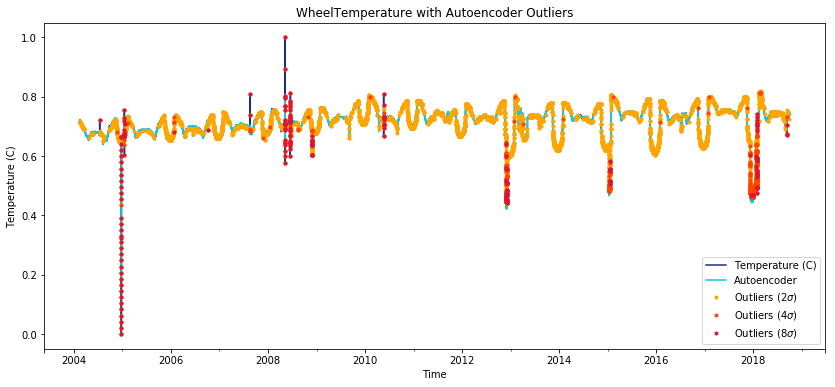

Detected outliers (WheelRPM, 2 stds): 6881
Detected outliers (WheelRPM, 4 stds): 2956
Detected outliers (WheelRPM, 8 stds): 2071


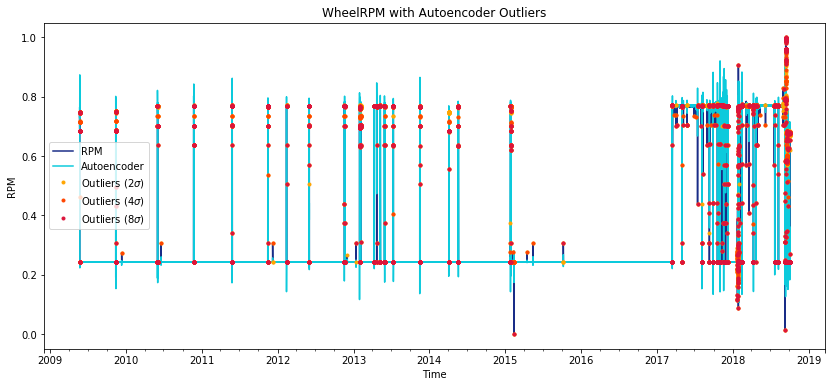

<Figure size 432x288 with 0 Axes>

In [9]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_with_autoencoder_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/100 percent/' + ds_name + '_autoencoder_full_outliers_from_error_mean.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_autoencoder_full_outliers_from_error_mean.csv' 
    
    data1, data2, data3 = detect_anomalies_with_many_stds(X, Y, ds_name, var_name, alg_name, outlier_def='errors', stds=[2,4,8],
                                                          plot_save_path=plot_file, data_save_path=data_file)
    

### Nonparametric dynamic thresholding

Detected outliers (BusVoltage): 560


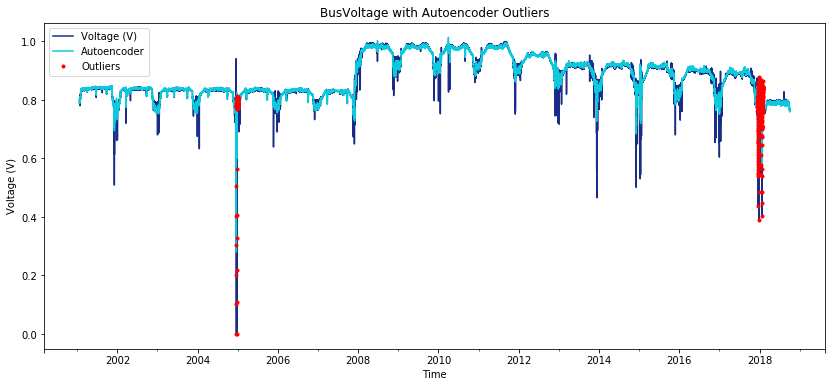

Detected outliers (TotalBusCurrent): 350


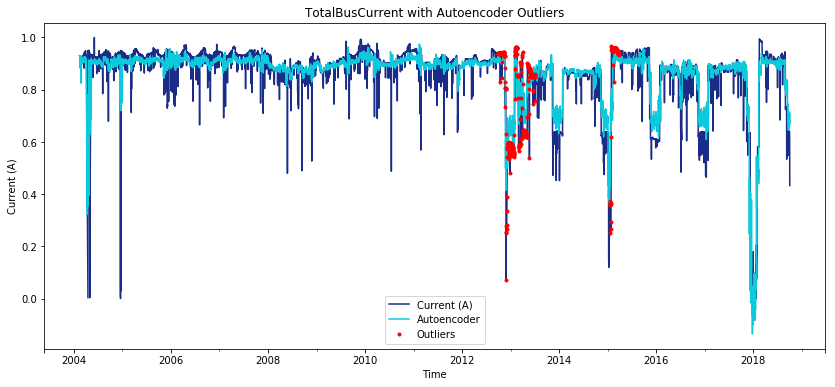

Detected outliers (BatteryTemperature): 490


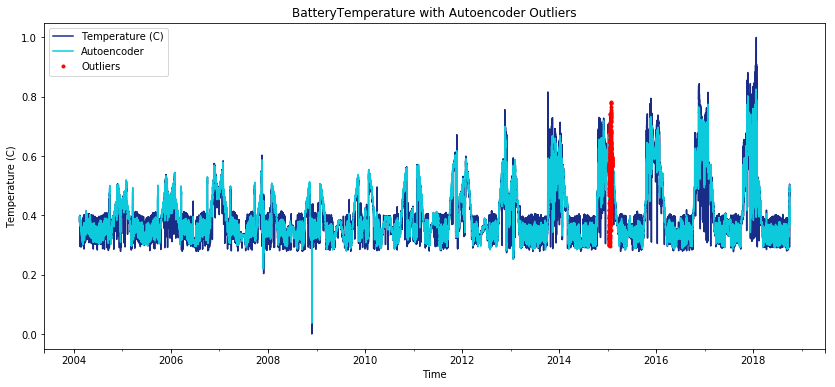

Detected outliers (WheelTemperature): 209


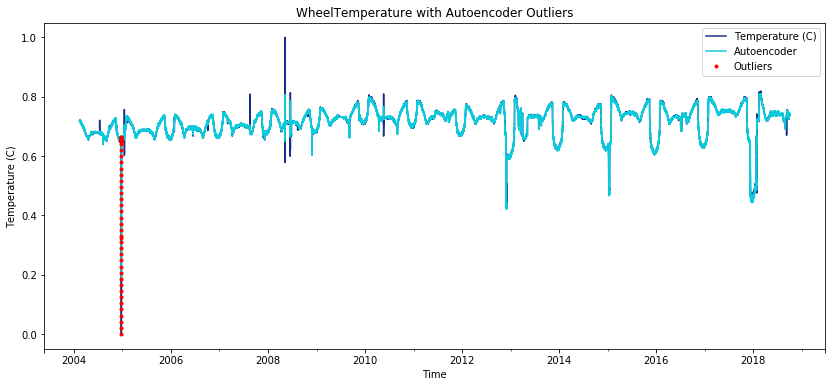

Detected outliers (WheelRPM): 977


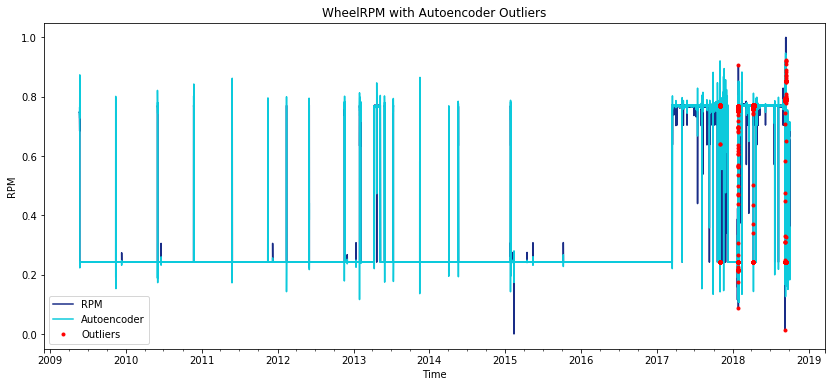

<Figure size 432x288 with 0 Axes>

In [16]:
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    
    file = 'save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_with_autoencoder_full.csv'
    ts_with_model = pd.read_csv(file, header=0, parse_dates=[0], index_col=0, date_parser=parser)
    
    var_name = ts_with_model.columns[0]
    alg_name = ts_with_model.columns[1]
    
    X = ts_with_model[var_name]
    Y = ts_with_model[alg_name]
    
    plot_file = './save/datasets/' + ds_name + '/autoencoder/plots/100 percent/' + ds_name + '_autoencoder_full_outliers_from_dynamic_thresholding.png' 
    data_file = './save/datasets/' + ds_name + '/autoencoder/data/100 percent/' + ds_name + '_autoencoder_full_outliers_from_dynamic_thresholding.csv' 
    
    data = detect_anomalies(X, Y, ds_name, var_name, alg_name, outlier_def='dynamic',
                            plot_save_path=plot_file, data_save_path=data_file)
    

## Combination Random Cut Forest

### Standard deviations from the mean of the errors

### Nonparametric dynamic thresholding

## Tables of Point Anomaly Counts
We saved a lot of data files while generating the above plots. Here we'll count how many point anomalies (a.k.a. outliers) were found in each file and save the counts as tables.

In [27]:
# Quick function to count the number of outliers in a data file
def count_outliers(file, outlier_col, start=0, end=None):
    ds = pd.read_csv(file)
    
    if end is None:
        ds = ds.iloc[start:]
    else:
        ds = ds.iloc[start:end]
        
    num_outliers = 0
    
    for index, row in ds.iterrows():
        if str(row[outlier_col]) == 'True':
            num_outliers = num_outliers + 1
            
    return num_outliers

In [28]:
std_algs = ['data_mean', 'error_mean']
stds = [2,4,8]
outlier_col = 'Outlier'

# Rolling Mean
rolling_mean_anomalies = pd.DataFrame()
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    rolling_mean_anomalies[ds_name] = 0.0  # add a column with this name
    
    data_dir = 'save/datasets/' + ds_name + '/rolling mean/data/'
    
    for alg in std_algs:
        for n in stds:
            file = data_dir + ds_name + '_rolling_mean_outliers_from_' + alg + '_' + str(n) + '_stds.csv'
            num_anoms = count_outliers(file, outlier_col)
            row_label = str(n) + 'σ' + ' from ' + alg.replace('_', ' ')
            
            rolling_mean_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
            
    file = data_dir + ds_name + '_rolling_mean_outliers_from_dynamic_thresholding.csv'
    num_anoms = count_outliers(file, outlier_col)  
    row_label = 'Nonparametric dynamic thresholding'
    rolling_mean_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
    rolling_mean_anomalies.to_csv('./save/rolling_mean_anomalies.csv')

    
# ARIMA (trained on first halves of datasets)
arima_test_set_anomalies = pd.DataFrame()
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    arima_test_set_anomalies[ds_name] = 0.0  # add a column with this name
    start = 0
    
    data_dir = 'save/datasets/' + ds_name + '/arima/data/50 percent/'
    
    for alg in std_algs:
        for n in stds:
            file = data_dir + ds_name + '_arima_half_outliers_from_' + alg + '_' + str(n) + '_stds.csv'
            
            # Skip first half of data to only count anomalies in test set
            df = pd.read_csv(file)
            start = int(len(df) / 2)
            
            num_anoms = count_outliers(file, outlier_col, start=start)
            row_label = str(n) + 'σ' + ' from ' + alg.replace('_', ' ')
            
            arima_test_set_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
            
    file = data_dir + ds_name + '_arima_half_outliers_from_dynamic_thresholding.csv'
    
    # Skip first half of data to only count anomalies in test set
    df = pd.read_csv(file)
    start = int(len(df) / 2)
            
    num_anoms = count_outliers(file, outlier_col, start)  
    row_label = 'Nonparametric dynamic thresholding'
    arima_test_set_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
    arima_test_set_anomalies.to_csv('./save/arima_test_set_anomalies.csv')

    
# ARIMA (overfit on whole datasets)
hyperparams = [
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=2920
{'order': (1,0,2), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=365
{'order': (0,1,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'n'},  # orig freq=8760
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'},  # orig freq=52560
{'order': (1,0,0), 'seasonal_order': (0,1,0) , 'freq': 365, 'trend': 'c'}   # orig freq=105120
] 

arima_anomalies_no_test = pd.DataFrame()
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    arima_anomalies_no_test[ds_name] = 0.0  # add a column with this name
    p = hyperparams[ds]['order'][0]
    freq = hyperparams[ds]['freq']
    start = 0
    
    data_dir = 'save/datasets/' + ds_name + '/arima/data/100 percent/'
    
    for alg in std_algs:
        for n in stds:
            file = data_dir + ds_name + '_arima_full_outliers_from_' + alg + '_' + str(n) + '_stds.csv'
            
            if (p == 1):  
                start = freq  # don't count data that was differenced away
            
            num_anoms = count_outliers(file, outlier_col, start=start)
            row_label = str(n) + 'σ' + ' from ' + alg.replace('_', ' ')
            
            arima_anomalies_no_test.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
            
    file = data_dir + ds_name + '_arima_full_outliers_from_dynamic_thresholding.csv'
    
    if (p == 1):  
        start = freq  # don't correlate with data that was differenced away
            
    num_anoms = count_outliers(file, outlier_col, start=start)  
    row_label = 'Nonparametric dynamic thresholding'
    arima_anomalies_no_test.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
    arima_anomalies_no_test.to_csv('./save/arima_anomalies_no_test.csv')
    

# Autoencoder (trained on first halves of datasets)
autoencoder_test_set_anomalies = pd.DataFrame()
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    autoencoder_test_set_anomalies[ds_name] = 0.0  # add a column with this name
    start = 0
    
    data_dir = 'save/datasets/' + ds_name + '/autoencoder/data/50 percent/'
    
    for alg in std_algs:
        for n in stds:
            file = data_dir + ds_name + '_autoencoder_half_outliers_from_' + alg + '_' + str(n) + '_stds.csv'
            
            # Skip first half of data to only count anomalies in test set
            df = pd.read_csv(file)
            start = int(len(df) / 2)
            
            num_anoms = count_outliers(file, outlier_col, start=start)
            row_label = str(n) + 'σ' + ' from ' + alg.replace('_', ' ')
            
            autoencoder_test_set_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
            
    file = data_dir + ds_name + '_autoencoder_half_outliers_from_dynamic_thresholding.csv'
    
    # Skip first half of data to only count anomalies in test set
    df = pd.read_csv(file)
    start = int(len(df) / 2)
            
    num_anoms = count_outliers(file, outlier_col, start)  
    row_label = 'Nonparametric dynamic thresholding'
    autoencoder_test_set_anomalies.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
    autoencoder_test_set_anomalies.to_csv('./save/autoencoder_test_set_anomalies.csv')
    

# Autoencoder (overfit on whole datasets)
autoencoder_anomalies_no_test = pd.DataFrame()
for ds in range(len(datasets)):
    ds_name = datasets[ds][5:-4] # drop 'Data/' and '.csv'
    autoencoder_anomalies_no_test[ds_name] = 0.0  # add a column with this name
    
    data_dir = 'save/datasets/' + ds_name + '/autoencoder/data/100 percent/'
    
    for alg in std_algs:
        for n in stds:
            file = data_dir + ds_name + '_autoencoder_full_outliers_from_' + alg + '_' + str(n) + '_stds.csv'
            num_anoms = count_outliers(file, outlier_col)
            row_label = str(n) + 'σ' + ' from ' + alg.replace('_', ' ')
            
            autoencoder_anomalies_no_test.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
            
    file = data_dir + ds_name + '_autoencoder_full_outliers_from_dynamic_thresholding.csv'
            
    num_anoms = count_outliers(file, outlier_col)  
    row_label = 'Nonparametric dynamic thresholding'
    autoencoder_anomalies_no_test.at[row_label, ds_name] = num_anoms  # Make the index [row_label] if it doesn't exist, place anomaly count
    autoencoder_anomalies_no_test.to_csv('./save/autoencoder_anomalies_no_test.csv')
    

# Combination Random Cut Forest
# (TODO)
combination_random_cut_forest_anomalies = pd.DataFrame()



### Rolling Mean

In [29]:
rolling_mean_anomalies

BusVoltage  TotalBusCurrent  \
2σ from data mean                         96.0            172.0   
4σ from data mean                         96.0            172.0   
8σ from data mean                         96.0            172.0   
2σ from error mean                      1688.0            241.0   
4σ from error mean                      1688.0            241.0   
8σ from error mean                      1688.0            241.0   
Nonparametric dynamic thresholding         0.0              0.0   

                                    BatteryTemperature  WheelTemperature  \
2σ from data mean                               1712.0           39720.0   
4σ from data mean                               1712.0           39720.0   
8σ from data mean                               1712.0           39720.0   
2σ from error mean                              5656.0           41741.0   
4σ from error mean                              5656.0           41741.0   
8σ from error mean                              5656.0           41741.0   
Nonparametric dynamic thresholding                 0.0               0.0   

                                    WheelRPM  
2σ from data mean                    19627.0  
4σ from data mean                    19627.0  
8σ from data mean                    19627.0  
2σ from error mean                   41375.0  
4σ from error mean                   41375.0  
8σ from error mean                   41375.0  
Nonparametric dynamic thresholding       0.0

### ARIMA (trained on first halves of datasets, test set outliers)

In [30]:
arima_test_set_anomalies

BusVoltage  TotalBusCurrent  \
2σ from data mean                       2032.0            550.0   
4σ from data mean                       2032.0            550.0   
8σ from data mean                       2032.0            550.0   
2σ from error mean                         0.0              0.0   
4σ from error mean                         0.0              0.0   
8σ from error mean                         0.0              0.0   
Nonparametric dynamic thresholding         0.0              0.0   

                                    BatteryTemperature  WheelTemperature  \
2σ from data mean                                242.0             446.0   
4σ from data mean                                242.0             446.0   
8σ from data mean                                242.0             446.0   
2σ from error mean                                 0.0               0.0   
4σ from error mean                                 0.0               0.0   
8σ from error mean                                 0.0               0.0   
Nonparametric dynamic thresholding                 0.0               0.0   

                                    WheelRPM  
2σ from data mean                      551.0  
4σ from data mean                      551.0  
8σ from data mean                      551.0  
2σ from error mean                       0.0  
4σ from error mean                       0.0  
8σ from error mean                       0.0  
Nonparametric dynamic thresholding       0.0

### ARIMA (overfit on whole datasets, all outliers)

In [31]:
arima_anomalies_no_test

BusVoltage  TotalBusCurrent  \
2σ from data mean                          9.0             30.0   
4σ from data mean                          9.0             30.0   
8σ from data mean                          9.0             30.0   
2σ from error mean                         0.0              0.0   
4σ from error mean                         0.0              0.0   
8σ from error mean                         0.0              0.0   
Nonparametric dynamic thresholding         0.0              0.0   

                                    BatteryTemperature  WheelTemperature  \
2σ from data mean                                 27.0              10.0   
4σ from data mean                                 27.0              10.0   
8σ from data mean                                 27.0              10.0   
2σ from error mean                                 0.0               0.0   
4σ from error mean                                 0.0               0.0   
8σ from error mean                                 0.0               0.0   
Nonparametric dynamic thresholding                 0.0               0.0   

                                    WheelRPM  
2σ from data mean                       57.0  
4σ from data mean                       57.0  
8σ from data mean                       57.0  
2σ from error mean                       0.0  
4σ from error mean                       0.0  
8σ from error mean                       0.0  
Nonparametric dynamic thresholding       0.0

### Autoencoder (trained on first halves of datasets, test set outliers)

In [32]:
autoencoder_test_set_anomalies

BusVoltage  TotalBusCurrent  \
2σ from data mean                         60.0            107.0   
4σ from data mean                         60.0            107.0   
8σ from data mean                         60.0            107.0   
2σ from error mean                       569.0            268.0   
4σ from error mean                       569.0            268.0   
8σ from error mean                       569.0            268.0   
Nonparametric dynamic thresholding         0.0              0.0   

                                    BatteryTemperature  WheelTemperature  \
2σ from data mean                                210.0               4.0   
4σ from data mean                                210.0               4.0   
8σ from data mean                                210.0               4.0   
2σ from error mean                              4089.0           10794.0   
4σ from error mean                              4089.0           10794.0   
8σ from error mean                              4089.0           10794.0   
Nonparametric dynamic thresholding                 0.0               0.0   

                                    WheelRPM  
2σ from data mean                       69.0  
4σ from data mean                       69.0  
8σ from data mean                       69.0  
2σ from error mean                    7018.0  
4σ from error mean                    7018.0  
8σ from error mean                    7018.0  
Nonparametric dynamic thresholding       0.0

### Autoencoder (overfit on whole datasets, all outliers)

In [33]:
autoencoder_anomalies_no_test

BusVoltage  TotalBusCurrent  \
2σ from data mean                         84.0             56.0   
4σ from data mean                         84.0             56.0   
8σ from data mean                         84.0             56.0   
2σ from error mean                       839.0            207.0   
4σ from error mean                       839.0            207.0   
8σ from error mean                       839.0            207.0   
Nonparametric dynamic thresholding         0.0              0.0   

                                    BatteryTemperature  WheelTemperature  \
2σ from data mean                                132.0              36.0   
4σ from data mean                                132.0              36.0   
8σ from data mean                                132.0              36.0   
2σ from error mean                              4006.0           18445.0   
4σ from error mean                              4006.0           18445.0   
8σ from error mean                              4006.0           18445.0   
Nonparametric dynamic thresholding                 0.0               0.0   

                                    WheelRPM  
2σ from data mean                       17.0  
4σ from data mean                       17.0  
8σ from data mean                       17.0  
2σ from error mean                    6881.0  
4σ from error mean                    6881.0  
8σ from error mean                    6881.0  
Nonparametric dynamic thresholding       0.0

### Combination Random Cut Forests

In [ ]:
# (TODO)
# combination_random_cut_forest_anomalies